In [1]:
# ! pip install sklearn

In [2]:
# Batchsize = 1024, 5 epochs in 

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as f1_score

from tqdm.notebook import tqdm
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
! nvidia-smi

Sun Jun 14 13:43:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   26C    P0    56W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   28C    P0    70W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc
def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr
def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [4]:
np.random.seed(42)

In [6]:
data_path = '/opt/recsys20_challenge/dataset/Training_20_M_Data.tsv'
columns   = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",
             "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",
             "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",
             "engaging_user_id", "engaging_user_follower_count", "engaging_user_following_count", "engaging_user_is_verified",
             "engaging_user_account_creation", "engagee_follows_engager", "reply_timestamp", "retweet_timestamp", 
             "retweet_with_comment_timestamp", "like_timestamp"]

In [7]:
len(columns)

24

In [8]:
%%time
colnames = ["reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]
df = pd.read_csv(data_path, sep='\x01', encoding='utf-8', header=None, usecols=[20, 21, 22, 23], names=colnames)

CPU times: user 38.2 s, sys: 2.3 s, total: 40.5 s
Wall time: 40.5 s


In [9]:
len(df)

20000000

In [10]:
labels_df = pd.DataFrame(index=df.index, columns=['id', 'like', 'reply', 'retweet', 'quote'])

In [11]:
labels_df['id'] = df.index
labels_df['like'] = 1 - np.isnan(df.like_timestamp).astype(int)
labels_df['quote'] = 1 - np.isnan(df.retweet_with_comment_timestamp).astype(int)
labels_df['retweet'] = 1 - np.isnan(df.retweet_timestamp).astype(int)
labels_df['reply'] = 1 - np.isnan(df.reply_timestamp).astype(int)

In [12]:
labels_df.head()

,id,like,reply,retweet,quote
0,0,1,0,0,0
1,1,0,0,0,0
2,2,1,0,0,0
3,3,1,0,0,0
4,4,1,0,0,0


In [13]:
labels_df.describe().loc['mean']

id         1.000000e+07
like       4.357225e-01
reply      2.590265e-02
retweet    1.099657e-01
quote      7.356200e-03
Name: mean, dtype: float64

In [36]:
%%time
tweet_features_train = np.load('/opt/recsys20_challenge/dataset/Data_Likes/XGBoost_Data/X_train_20_M.npy')
tweet_features_test = np.load('/opt/recsys20_challenge/dataset/Data_Likes/XGBoost_Data/X_test_20_M.npy')
l = ['present_domains', 'tweet_type', 'language',
       'present_media', 'engagee_follows_engager', 'hashtags',
       'engaging_user_follower_count', 'engaging_user_following_count',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'users_int', 'authors_int',
       'nb_likes', 'nb_reply', 'nb_retweet', 'nb_retweet_C',
       'nb_likes_author', 'nb_reply_author', 'nb_retweet_author', 'nb_retweet_C_author',
       'author_class',
       'engaging_user_account_creation', 'engaged_with_user_account_creation',
       'engaged_with_user_is_verified', 'engaging_user_is_verified']

CPU times: user 0 ns, sys: 2.16 s, total: 2.16 s
Wall time: 2.16 s


In [42]:
tweet_features_train.shape

(18000000, 28)

In [28]:
%%time
tfidf_preds = pd.concat([pd.read_csv('~/recsys20_challenge/code_ismail/predictions/likes_20M_sgdc_tfidf.csv'),
                         pd.read_csv('~/recsys20_challenge/code_ismail/predictions/quotes_20M_sgdc_tfidf.csv'),
                         pd.read_csv('~/recsys20_challenge/code_ismail/predictions/replys_20M_sgdc_tfidf.csv'),
                         pd.read_csv('~/recsys20_challenge/code_ismail/predictions/retweets_20M_sgdc_tfidf.csv')], axis=1)

CPU times: user 26.8 s, sys: 2.64 s, total: 29.4 s
Wall time: 29.4 s


In [29]:
tfidf_preds.shape

(20000000, 16)

In [355]:
action = 'quote'

In [356]:
tfidf_preds_cols = tfidf_preds[['no_'+action+'_softmax', action+'_softmax', action+'_prediction']]

In [357]:
tfidf_preds_cols.head()

,no_quote_softmax,quote_softmax,quote_prediction
0,0.993613,0.006387,0
1,0.986777,0.013223,0
2,0.986925,0.013075,0
3,0.980357,0.019643,0
4,0.988843,0.011157,0


In [358]:
tfidf_preds_cols.shape

(20000000, 3)

In [359]:
min_max_scaler = preprocessing.MinMaxScaler()
tweet_features = np.concatenate([tweet_features_test, tweet_features_train])
tweet_features = min_max_scaler.fit_transform(tweet_features).astype(float)
tweet_features = np.nan_to_num(tweet_features)

In [360]:
tweet_features = np.concatenate([tweet_features, tfidf_preds_cols.values], axis=1)

In [361]:
tweet_features.shape

(20000000, 31)

In [362]:
pd.DataFrame(tweet_features).describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
count,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,...,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07
mean,5.163856e-01,6.531042e-01,4.481485e-01,3.762195e-01,3.330120e-01,4.855545e-01,1.228323e-05,3.273889e-04,1.309609e-02,1.270787e-03,...,6.483333e-05,5.854350e-04,1.360000e-05,9.179390e-01,8.800913e-01,2.761560e-01,2.224650e-03,9.920965e-01,7.903522e-03,1.000000e-06
std,9.915331e-02,4.647267e-01,1.106916e-01,2.128824e-01,4.712908e-01,7.968203e-02,4.739525e-04,9.999019e-04,6.324873e-02,1.067131e-02,...,4.835772e-03,1.002032e-02,2.250885e-03,6.447714e-02,7.270879e-02,4.470949e-01,4.711370e-02,5.803932e-03,5.803932e-03,9.999995e-04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.642419e-01,1.910529e-04,0.000000e+00
25%,5.488460e-01,0.000000e+00,4.333993e-01,2.223074e-01,0.000000e+00,4.941370e-01,5.718904e-07,6.682946e-05,1.208472e-05,4.452404e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,8.661187e-01,8.145096e-01,0.000000e+00,0.000000e+00,9.902614e-01,4.762428e-03,0.000000e+00
50%,5.488460e-01,1.000000e+00,4.333993e-01,2.223074e-01,0.000000e+00,4.941370e-01,2.173183e-06,1.495707e-04,1.547873e-04,1.241276e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,9.329136e-01,8.769896e-01,0.000000e+00,0.000000e+00,9.931014e-01,6.898592e-03,0.000000e+00
75%,5.488460e-01,1.000000e+00,5.083510e-01,5.708352e-01,1.000000e+00,4.941370e-01,6.505253e-06,3.235395e-04,2.134868e-03,3.310070e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,9.760732e-01,9.479869e-01,1.000000e+00,0.000000e+00,9.952376e-01,9.738621e-03,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.998089e-01,5.357581e-01,1.000000e+00


In [363]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, extra_features, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.extra_features = extra_features
        assert(len(labels) == len(extra_features))

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        # X = np.load(f'/opt/recsys20_challenge/bert_embeddings/train_2M/avg/{ID}_avg.npy')
        # if np.sum(np.isnan(X)) > 0:  X = np.zeros(X.shape, X.dtype)
        # X = torch.tensor(X) # .to('cuda')
        T = torch.tensor(self.extra_features[ID]).float()
        y = self.labels[ID]

        return T, y

In [364]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Device:', device)
torch.backends.cudnn.benchmark = True

Device: cuda


In [365]:
labels_df.values[:, 1]

array([1, 0, 1, ..., 1, 1, 1])

In [366]:
labels_df[action].values

array([0, 0, 0, ..., 0, 0, 0])

In [367]:
# from tqdm.notebook import tqdm 
params = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 16}

# Datasets
list_IDs  = labels_df.values[:, 0]
labels    = labels_df[action].values
oh_labels = np.eye(2)[labels].astype(int)

test_len = int(0.1*len(labels_df))
train_IDs, val_IDs = list_IDs[test_len:], list_IDs[:test_len]
train_df = labels_df.iloc[train_IDs]

pos = list(train_df[train_df[action] == 1].index)
neg = list(np.random.choice(train_df[train_df[action] == 0].index, len(pos), replace=False))
train_balanced_IDs = pos + neg
small_IDs = train_IDs[:10000]
partition = {'train': train_IDs, 'validation': val_IDs, 'balanced': train_balanced_IDs, 'small': small_IDs}

# Generators
training_set = Dataset(partition['train'], tweet_features, labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], tweet_features, labels)
validation_generator = data.DataLoader(validation_set, **params)

In [368]:
training_eval_set = Dataset(partition['train'], tweet_features, labels)
training_eval_generator = data.DataLoader(training_set, **{'batch_size': 1024,
                                                          'shuffle': False,
                                                          'num_workers': 32})

In [369]:
print(0, ':\t', len(labels) - np.count_nonzero(labels))
print(1, ':\t', np.count_nonzero(labels))

0 :	 19852876
1 :	 147124


In [370]:
# Training
for local_features, local_labels in validation_generator:
    # Transfer to GPU
    # print(local_emnbeddings.shape)
    print(local_features.shape)
    print(local_labels.shape)
    print(local_emnbeddings[0][:10])
    print(local_features[0][:10])
    break

torch.Size([512, 31])
torch.Size([512])
tensor([ 0.0609, -0.5045, -0.1694,  0.0894,  0.5763,  0.0122, -0.1973,  0.4256,
        -0.2736, -0.1927])
tensor([5.4885e-01, 1.0000e+00, 4.1039e-01, 2.2231e-01, 1.0000e+00, 0.0000e+00,
        2.4162e-06, 1.5700e-04, 4.7807e-05, 6.9664e-04])


# fc with MeanSquareLoss

Following this example: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [371]:
def backprop(T, y, model, optimizer, loss_fn):
    # print(X[0][:10])
    # print(output.shape, y.shape)
    # print(output[0], y[0])

    output = model(T)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [372]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, tweet_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super().__init__()
        torch.manual_seed(42)
        self.fc1 = nn.Linear(tweet_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

        # extra layers layers
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim)

        
    def forward(self, t):
        x = self.fc1(t)
        x = self.dropout(x)
        x = self.relu(x)
        
        logits = self.fc2(x)

        return logits

In [392]:
%%time
model_params = {'tweet_dim': 31,
                'hidden_dim': 100,
                'dropout_rate': 0.2,
                'output_dim': 2}

train_losses = {}
val_results  = {}

log_interval = 10000

ffnet     = FeedForwardNetwork(**model_params).to('cuda')

CPU times: user 69.4 ms, sys: 23.7 ms, total: 93.1 ms
Wall time: 90 ms


In [393]:
weights = np.power(labels_df.iloc[train_IDs][action].value_counts().values, 1)
weights = max(weights) * 1 / weights
weights = torch.Tensor(weights).to('cuda')
weights = torch.Tensor([1, 5.]).to('cuda')

In [394]:
optimizer_params = {'lr': 1.,
                    #'momentum': 0.9,}
                    'weight_decay': 1e-6}

loss_fn   = nn.CrossEntropyLoss() #(weight=weights) 
optimizer = torch.optim.SGD(ffnet.parameters(), **optimizer_params)
# optimizer = torch.optim.SGD(ffnet.parameters(), lr=learning_rate)#, momentum=0.9)

In [395]:
# learning_rate = 0.001 #3e-4

In [396]:
%%time
max_epochs = 7
for epoch in range(len(val_results), len(val_results) + max_epochs):
    # Training
    ffnet.train()
    print('Epoch', epoch)
    train_losses[epoch] = []

    for batch, (batch_features, batch_labels) in enumerate(tqdm(training_generator)):
        # tranfer to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        l = backprop(batch_features, batch_labels, ffnet, optimizer, loss_fn)
        train_losses[epoch].append(l)
        
        if batch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(batch_features), len(training_generator.dataset),
                100. * batch / len(training_generator), l))    
    print(f'Average loss on epoch {epoch}: {np.mean(train_losses[epoch])}')
    
    # Validation
    ffnet.eval()
    with torch.no_grad():
        val_results[epoch] = {'out':[], 'gt':[]}
        for batch, (batch_features, batch_labels) in enumerate(tqdm(validation_generator)):
            # Transfer to GPU
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            logits_output = ffnet(batch_features)
            val_results[epoch]['out'].append(logits_output.cpu())
            val_results[epoch]['gt'].append(batch_labels.cpu())
    
        all_out = [l for batch in val_results[epoch]['out'] for l in batch.numpy()]
        all_gt  = [l for batch in val_results[epoch]['gt'] for l in batch.numpy()]
        
        y_pred = softmax(all_out)[:, 1]
        y_pred[y_pred == 1] = 0.99
        # print('NaN elements: ', len(np.where(np.isnan(all_out))[0]))
        print('PRAUC:', compute_prauc(y_pred, all_gt) * 100)
        print('RCE:', compute_rce(y_pred, all_gt))

Epoch 0


Train Epoch: 0 [0/18000000 (0%)]	Loss: 0.657161
Train Epoch: 0 [5120000/18000000 (28%)]	Loss: 0.015991
Train Epoch: 0 [10240000/18000000 (57%)]	Loss: 0.031710
Train Epoch: 0 [15360000/18000000 (85%)]	Loss: 0.026430

Average loss on epoch 0: 0.04175445936234085



PRAUC: 5.015661853912621
RCE: -27.794818690326917
Epoch 1


Train Epoch: 1 [0/18000000 (0%)]	Loss: 0.048488
Train Epoch: 1 [5120000/18000000 (28%)]	Loss: 0.086476
Train Epoch: 1 [10240000/18000000 (57%)]	Loss: 0.026735
Train Epoch: 1 [15360000/18000000 (85%)]	Loss: 0.013907

Average loss on epoch 1: 0.03968061428668443



PRAUC: 5.821182040100561
RCE: -0.35925864443779876
Epoch 2


Train Epoch: 2 [0/18000000 (0%)]	Loss: 0.036898
Train Epoch: 2 [5120000/18000000 (28%)]	Loss: 0.028129
Train Epoch: 2 [10240000/18000000 (57%)]	Loss: 0.068539
Train Epoch: 2 [15360000/18000000 (85%)]	Loss: 0.012300

Average loss on epoch 2: 0.03868282060859552



PRAUC: 6.25670596705325
RCE: 3.202074311800407
Epoch 3


Train Epoch: 3 [0/18000000 (0%)]	Loss: 0.047885
Train Epoch: 3 [5120000/18000000 (28%)]	Loss: 0.026299
Train Epoch: 3 [10240000/18000000 (57%)]	Loss: 0.054550
Train Epoch: 3 [15360000/18000000 (85%)]	Loss: 0.066492

Average loss on epoch 3: 0.03815612466332198



PRAUC: 7.101957968384712
RCE: -36.19887651610887
Epoch 4


Train Epoch: 4 [0/18000000 (0%)]	Loss: 0.048097
Train Epoch: 4 [5120000/18000000 (28%)]	Loss: 0.033674
Train Epoch: 4 [10240000/18000000 (57%)]	Loss: 0.062215
Train Epoch: 4 [15360000/18000000 (85%)]	Loss: 0.028394

Average loss on epoch 4: 0.0378407609317833



PRAUC: 6.867512471822411
RCE: 2.1653948056407413
Epoch 5


Train Epoch: 5 [0/18000000 (0%)]	Loss: 0.041038
Train Epoch: 5 [5120000/18000000 (28%)]	Loss: 0.046677
Train Epoch: 5 [10240000/18000000 (57%)]	Loss: 0.043556
Train Epoch: 5 [15360000/18000000 (85%)]	Loss: 0.045407

Average loss on epoch 5: 0.037622065584918055



PRAUC: 7.142428972401261
RCE: 7.828156825763733
Epoch 6


Train Epoch: 6 [0/18000000 (0%)]	Loss: 0.022364
Train Epoch: 6 [5120000/18000000 (28%)]	Loss: 0.040226
Train Epoch: 6 [10240000/18000000 (57%)]	Loss: 0.026331
Train Epoch: 6 [15360000/18000000 (85%)]	Loss: 0.045369

Average loss on epoch 6: 0.03747488118414528



PRAUC: 7.293219967138742
RCE: 7.973309393624373
CPU times: user 14min 42s, sys: 3min 2s, total: 17min 45s
Wall time: 18min 27s


In [340]:
metrics = ['Accuracy', 'F1-score', 'PRAUC', 'RCE']
scores  = {m: [] for m in metrics}
scores_rand =  {m: [] for m in metrics}

for epoch in val_results:
    scores[epoch] = {}
    scores_rand[epoch] = {}
    
    all_out = [l for batch in val_results[epoch]['out'] for l in batch.numpy()]
    all_gt  = [l for batch in val_results[epoch]['gt'] for l in batch.numpy()]
    all_rand = np.random.rand(len(all_gt), 2)
    
    all_out = np.nan_to_num(all_out)
    y_pred = softmax(all_out)[:, 1]
    y_pred[y_pred == 1] = 0.99

    scores['PRAUC'].append(compute_prauc(y_pred, all_gt) * 100)
    scores['RCE'].append(compute_rce(y_pred, all_gt))
    scores_rand['PRAUC'].append(compute_prauc(softmax(all_rand)[:, 1], all_gt) * 100)
    scores_rand['RCE'].append(compute_rce(softmax(all_rand)[:, 1], all_gt) * 100)
    
    print('\nEPOCH', epoch)
    # print('Accuracy', scores['Accuracy'][-1])
    print('PRAUC', scores['PRAUC'][-1])
    print('RCE', scores['RCE'][-1])



EPOCH 0
PRAUC 11.762930644700951
RCE 9.434550772406347


<Figure size 640x480 with 0 Axes>

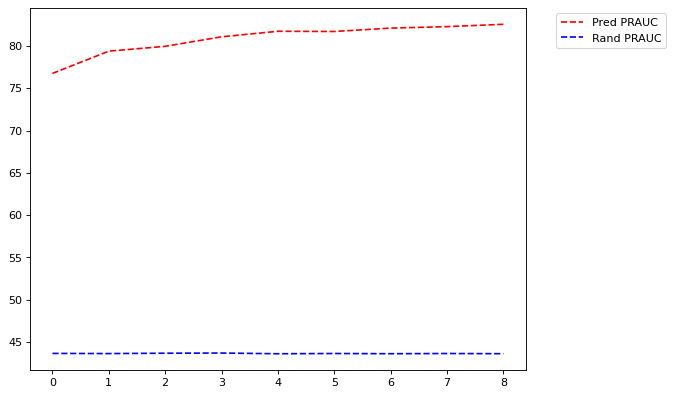

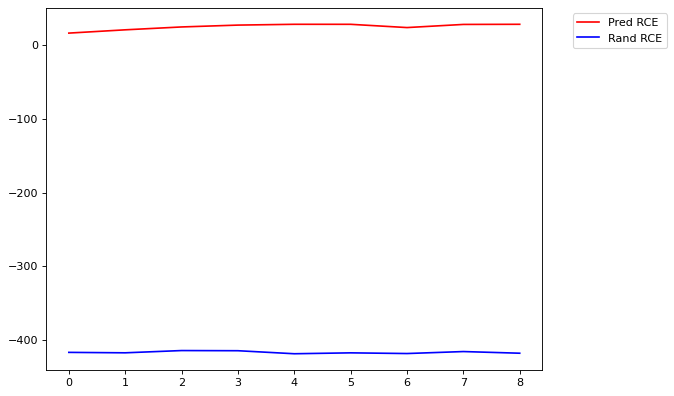

In [129]:
figure(figsize=(8, 6), dpi=80)

epochs = range(len(val_results))
figure(figsize=(8, 6), dpi=80)
# plt.plot(epochs, scores['Accuracy'],     'r^', label='Pred Acc')

# plt.plot(epochs, scores['F1-score'], 'r-', label='Pred F1')
# plt.plot(epochs, scores_rand['F1-score'], 'b-', label='Rand F1')
plt.plot(epochs, scores['PRAUC'], 'r--', label='Pred PRAUC')
plt.plot(epochs, scores_rand['PRAUC'], 'b--', label='Rand PRAUC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

figure(figsize=(8, 6), dpi=80)

plt.plot(epochs, scores['RCE'], 'r-', label='Pred RCE')
plt.plot(epochs, scores_rand['RCE'],'b-', label='Rand RCE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [37]:
""" Outputting results with logit scores

df_out = pd.DataFrame(columns=['id', 'no_like_score', 'like_score', 'no_like_softmax', 'like_softmax', 'like_prediction', 'like_gt'])
df_out['id'] = val_IDs
df_out = df_out.set_index('id')

df_out[['no_like_score', 'like_score']] = all_out
df_out[['no_like_softmax', 'like_softmax']] = softmax(all_out)

df_out['like_prediction'] = np.argmax(all_out, axis=1)
df_out['like_gt'] = all_gt
"""

In [51]:
"""
ffnet.eval()
with torch.no_grad():
    train_results = {'out':[], 'gt':[]}
    for local_batch, local_labels in tqdm(training_eval_generator):
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        logits_output = ffnet(local_batch) #.float()
        train_results['out'].append(logits_output.cpu())
        train_results['gt'].append(local_labels.cpu())

    all_out = [l for batch in train_results['out'] for l in batch.numpy()]
    all_gt  = [l for batch in train_results['gt'] for l in batch.numpy()]

    print('PRAUC:', compute_prauc(softmax(all_out)[:, 1], all_gt) * 100)
    print('RCE:', compute_rce(softmax(all_out)[:, 1], all_gt))
"""


PRAUC: 53.22577980474714
RCE: 1.6421294450501


# Generating output for Eval Set

In [130]:
%%time
# eval_df = pd.read_csv('/opt/recsys20_challenge/dataset/eval.tsv', sep='\x01', encoding='utf-8', header=None, names=["tweet_id", 'engaging_id'], usecols=[2, 14])

CPU times: user 46.6 s, sys: 2.36 s, total: 49 s
Wall time: 49.1 s


In [134]:
eval_df.head()

,tweet_id,engaging_id
0,7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB
1,408DB1803264B5FF55F73EC06BE9BD77,000013315386492275CCBF7AEF293EF0
2,2EE951379C47E8BF62EABB8FA027F753,00001569CB28972FC8173122D9DA162F
3,2135F24B05DAE3EF213F9CE80FDC6DAF,00001607209C5774DF9207A2AC0EED5F
4,09143FEDE9BD494A6EA9A7EE160565E3,0000177705514C315F2FC6DFA3872712


In [397]:
%%time
tweet_features_eval = np.load('/opt/recsys20_challenge/dataset/Data_Likes/XGBoost_Data/X_eval.npy')
print(tweet_features_eval.shape)

(12434735, 28)
CPU times: user 0 ns, sys: 1.35 s, total: 1.35 s
Wall time: 1.35 s


In [398]:
%%time
#tfidf_preds_eval = pd.concat([pd.read_csv('~/recsys20_challenge/code_ismail/predictions/likes_eval_sgdc_tfidf.csv'),
#                         pd.read_csv('~/recsys20_challenge/code_ismail/predictions/quotes_eval_sgdc_tfidf.csv'),
#                         pd.read_csv('~/recsys20_challenge/code_ismail/predictions/replys_eval_sgdc_tfidf.csv'),
#                         pd.read_csv('~/recsys20_challenge/code_ismail/predictions/retweets_eval_sgdc_tfidf.csv')], axis=1)

print(tfidf_preds_eval.shape)

(12434735, 24)
CPU times: user 0 ns, sys: 125 µs, total: 125 µs
Wall time: 132 µs


In [399]:
tfidf_preds_eval_cols = tfidf_preds_eval[['no_'+action+'_softmax', action+'_softmax', action+'_prediction']]

print(tfidf_preds_eval_cols.shape)

(12434735, 3)


In [400]:
tfidf_preds_eval_cols.head()

,no_quote_softmax,quote_softmax,quote_prediction
0,0.991463,0.008537,0
1,0.993935,0.006065,0
2,0.990609,0.009391,0
3,0.991152,0.008848,0
4,0.993629,0.006371,0


In [401]:
min_max_scaler = preprocessing.MinMaxScaler()
tweet_features_eval = min_max_scaler.fit_transform(tweet_features_eval).astype(float)
tweet_features_eval = np.nan_to_num(tweet_features_eval)
tweet_features_eval = np.concatenate([tweet_features_eval, tfidf_preds_eval_cols.values], axis=1)

print(tweet_features_eval.shape)

(12434735, 31)


In [402]:
class EvalDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, extra_features):
        'Initialization'
        self.list_IDs = list_IDs
        self.extra_features = extra_features

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        T = torch.tensor(self.extra_features[ID]).float()
        return T

In [403]:
eval_set = EvalDataset(eval_df.index, tweet_features_eval)
eval_generator = data.DataLoader(eval_set, shuffle=False, batch_size=85, num_workers=16)

In [404]:
for local_batch in eval_generator:
    # Transfer to GPU
    print(local_batch.shape)
    print(local_batch[0])
    break

torch.Size([85, 31])
tensor([0.0000e+00, 1.0000e+00, 4.3340e-01, 6.0791e-01, 1.0000e+00, 0.0000e+00,
        2.5237e-04, 3.7861e-04, 1.2340e-04, 2.7361e-04, 0.0000e+00, 1.5152e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6989e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.6298e-01, 9.1697e-01, 0.0000e+00, 0.0000e+00, 9.9146e-01, 8.5374e-03,
        0.0000e+00])


In [405]:
%%time
like_logits = []
like_scores = []
with torch.no_grad():
    for local_batch in tqdm(eval_generator):
        # Transfer to GPU
        local_batch = local_batch.to(device)
        logits_output = ffnet(local_batch) #.float()
        like_logits.append(logits_output.cpu())


CPU times: user 2min 15s, sys: 29.3 s, total: 2min 44s
Wall time: 2min 51s


In [406]:
len(like_logits)

146291

In [298]:
logits = np.concatenate([l.numpy() for l in like_logits])

In [299]:
logits.shape

(12434735, 2)

In [407]:
all_out = [l for batch in like_logits for l in batch.numpy()]

y_pred = softmax(all_out)[:, 1]
y_pred[y_pred == 1] = 0.99

In [408]:
y_pred.shape

(12434735,)

In [409]:
eval_df['predictions'] = y_pred

In [410]:
eval_df.tail()

,tweet_id,engaging_id,predictions
12434730,9ABED4B0AB2CAA18BD6248064C2502C5,FFFFF11D9F54702F82D4386907FA1EB4,0.004304
12434731,EFCAC0A88CC0B00C382E7D0C6B524C91,FFFFF41EF74BC4EA75C33EC85FE16513,0.001432
12434732,BE3AF4D2D7F17451A9BB6959019F4316,FFFFF785504753651FF3EF40B304840E,0.005167
12434733,4A5F639729D6DDB69BA5DD2B334728C4,FFFFFB2D8B6FD1034804A4B740CB16BC,0.003246
12434734,B1AFB06AB12B2B261C7D35F67D654742,FFFFFE97AA06327403491D71E2ED52DA,0.000871


In [411]:
eval_df.to_csv('predictions/'+action+'s_eval_nn_tfidf_tweet.csv', header=False, index=False)